# 10:30 hours of execution time didn't cut it for the first version
Here I'm exploring a second version

## Input parsing

In [3]:
import numpy as np
grid100 = np.array( [ list(map(int, line)) for line in open("puzzle15.txt").read().split("\n") ])
startingPosition = (0, 0)
target1 = (99,99); w1 = 100
target2 = (499, 499); w2 = 100

grid500 = None
for i in range(5):
    largerRow = None
    for j in range(5):
        increment = i + j
        newTile = np.where((grid100 + increment) < 10 , grid100 + increment, (grid100 + increment) - 9)
        if largerRow is None: largerRow = newTile
        else: largerRow = np.concatenate((largerRow, newTile), axis = 1)
    if grid500 is None: grid500 = largerRow
    else: grid500 = np.concatenate((grid500, largerRow), axis = 0)

## New numpy based dijkstra solution
This one brought down the time for grid100 from ~19s to 0.9s! That's great.
It also worked on grid500 bringing the time down from 10:30 hours to 6:53 minutes.

In [11]:
def dijkstra(grid : np.ndarray, source : tuple[int, int] = (0,0)):    
    width = grid.shape[0]
    dist = np.ones((width, width), dtype=int) * np.Infinity; dist[source] = 0
    prev = np.ones((width, width), dtype=int) * np.nan
    seen = np.zeros((width, width), dtype=bool)
    posy, posx = source
    iter = 0
    while posy != width - 1 or posx != width - 1:
        iter += 1
        if iter % 1000 == 0: print(iter)
        neighbours = [
            n for n in 
                [(posy - 1, posx), (posy + 1, posx), (posy, posx - 1), (posy, posx + 1)]
            if 0<=n[0]<width and 0<=n[1]<width and not seen[n]]
        for n in neighbours:
            alt = dist[posy, posx] + grid[n]
            if alt < dist[n]:
                dist[n] = alt
                prev[n] = np.ravel_multi_index([posy, posx], (width, width))
        seen[posy, posx] = True
        
        # This can be updated with a min-priority queue
        dismaptemp=dist
        dismaptemp[np.where(seen)]=np.Infinity
        minPost =np.unravel_index(np.argmin(dismaptemp),(width, width))
        posy, posx = minPost[0], minPost[1]
        
    return dist, prev, seen



In [ ]:
d1, p1, s1 = dijkstra(grid100) # 0.9s
d2, p2, s2 = dijkstra(grid500) # 6m53s

# Optimization time!
Reading about using a priority queue to find the next node to check, it's cleat that the issue is the lines at the end of the while loop.
This new function provides a naive implementation of the min queue.
Initially I was raveling the y,x multi index before appending it into the queue. This brought *UP* the time for grid100 to 2.2s and the and down the time for grid500 to 4m05s.
I tried changing the queue values to be the (y,x) tuples instead of the raveled index and it brought down the time for grid100 to 0.2s and the time for grid500 to 21.8s!!!

In [45]:
def dijkstra_minqueue(grid : np.ndarray, source : tuple[int, int] = (0,0)):
    width = grid.shape[0]
    dist = np.ones((width, width), dtype=int) * np.Infinity; dist[source] = 0
    prev = np.ones((width, width), dtype=int) * np.nan
    seen = np.zeros((width, width), dtype=bool)
    Q = []

    def insertNodeInQueue(py, px, value):
        index = 0; queueLen = len(Q)
        while index < queueLen:
            if dist[Q[index]] >= value:
                Q.insert(index, (py, px))
                return
            index += 1
        Q.append((py, px))

    posy, posx = source
    while posy != width - 1 or posx != width - 1:
        neighbours = [
            n for n in 
                [(posy - 1, posx), (posy + 1, posx), (posy, posx - 1), (posy, posx + 1)]
            if 0<=n[0]<width and 0<=n[1]<width and not seen[n]]
        for n in neighbours:
            alt = dist[posy, posx] + grid[n]
            if alt < dist[n]:
                dist[n] = alt
                prev[n] = np.ravel_multi_index([posy, posx], (width, width))
                insertNodeInQueue(n[0], n[1], dist[n])
        seen[posy, posx] = True
        posy, posx = Q.pop(0)
        
    return dist, prev, seen



In [49]:
d1o, p1o, s1o = dijkstra_minqueue(grid100)
print("Minimal risk level path has a value of:", d1o[99,99])

Minimal risk level path has a value of: 456.0


In [58]:
d2o, p2o, s2o = dijkstra_minqueue(grid500)
print("Minimal risk level path has a value of:", d2o[499,499])

Minimal risk level path has a value of: 2831.0


# Extracting the paths from the previous node matrices

In [60]:
path1 = []; path2 = []
row, col = 99, 99
while (row, col) != (0,0):
    path1.append((row, col))
    row, col = np.unravel_index(int(p1o[row, col]), (100, 100))
path1.append((0,0))
row, col = 499, 499
while (row, col) != (0,0):
    path2.append((row, col))
    row, col = np.unravel_index(int(p2o[row, col]), (500, 500))
path2.append((0,0))

### ABSURDLY SLOW image rendering

In [72]:
from PIL import Image
img100 = Image.new("RGBA", (100, 100), (0,0,0,0))
img500 = Image.new("RGBA", (500, 500), (0,0,0,0))
pixels500 = []; pixels100 = []
grayscale = [(int(255 - (x / 10) * 255),int(255 - (x / 10) * 255),int(255 - (x / 10) * 255), 255) for x in range(9)]
for r in range(500):
    for c in range(500):
        if (r, c) in path2:
            pixels500.append((255,0,0,255))
        else:
            pixels500.append(grayscale[grid500[r,c] - 1])
        if c < 100 and r < 100:
            if (r, c) in path1:
                pixels100.append((255,0,0,255))
            else:
                pixels100.append(grayscale[grid100[r,c] - 1])
img100.putdata(pixels100)
img500.putdata(pixels500)
img100 = img100.resize((400,400), Image.NEAREST)
img500 = img500.resize((2000,2000), Image.NEAREST)


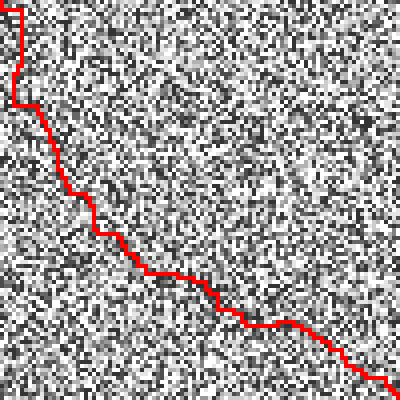

In [73]:
img100

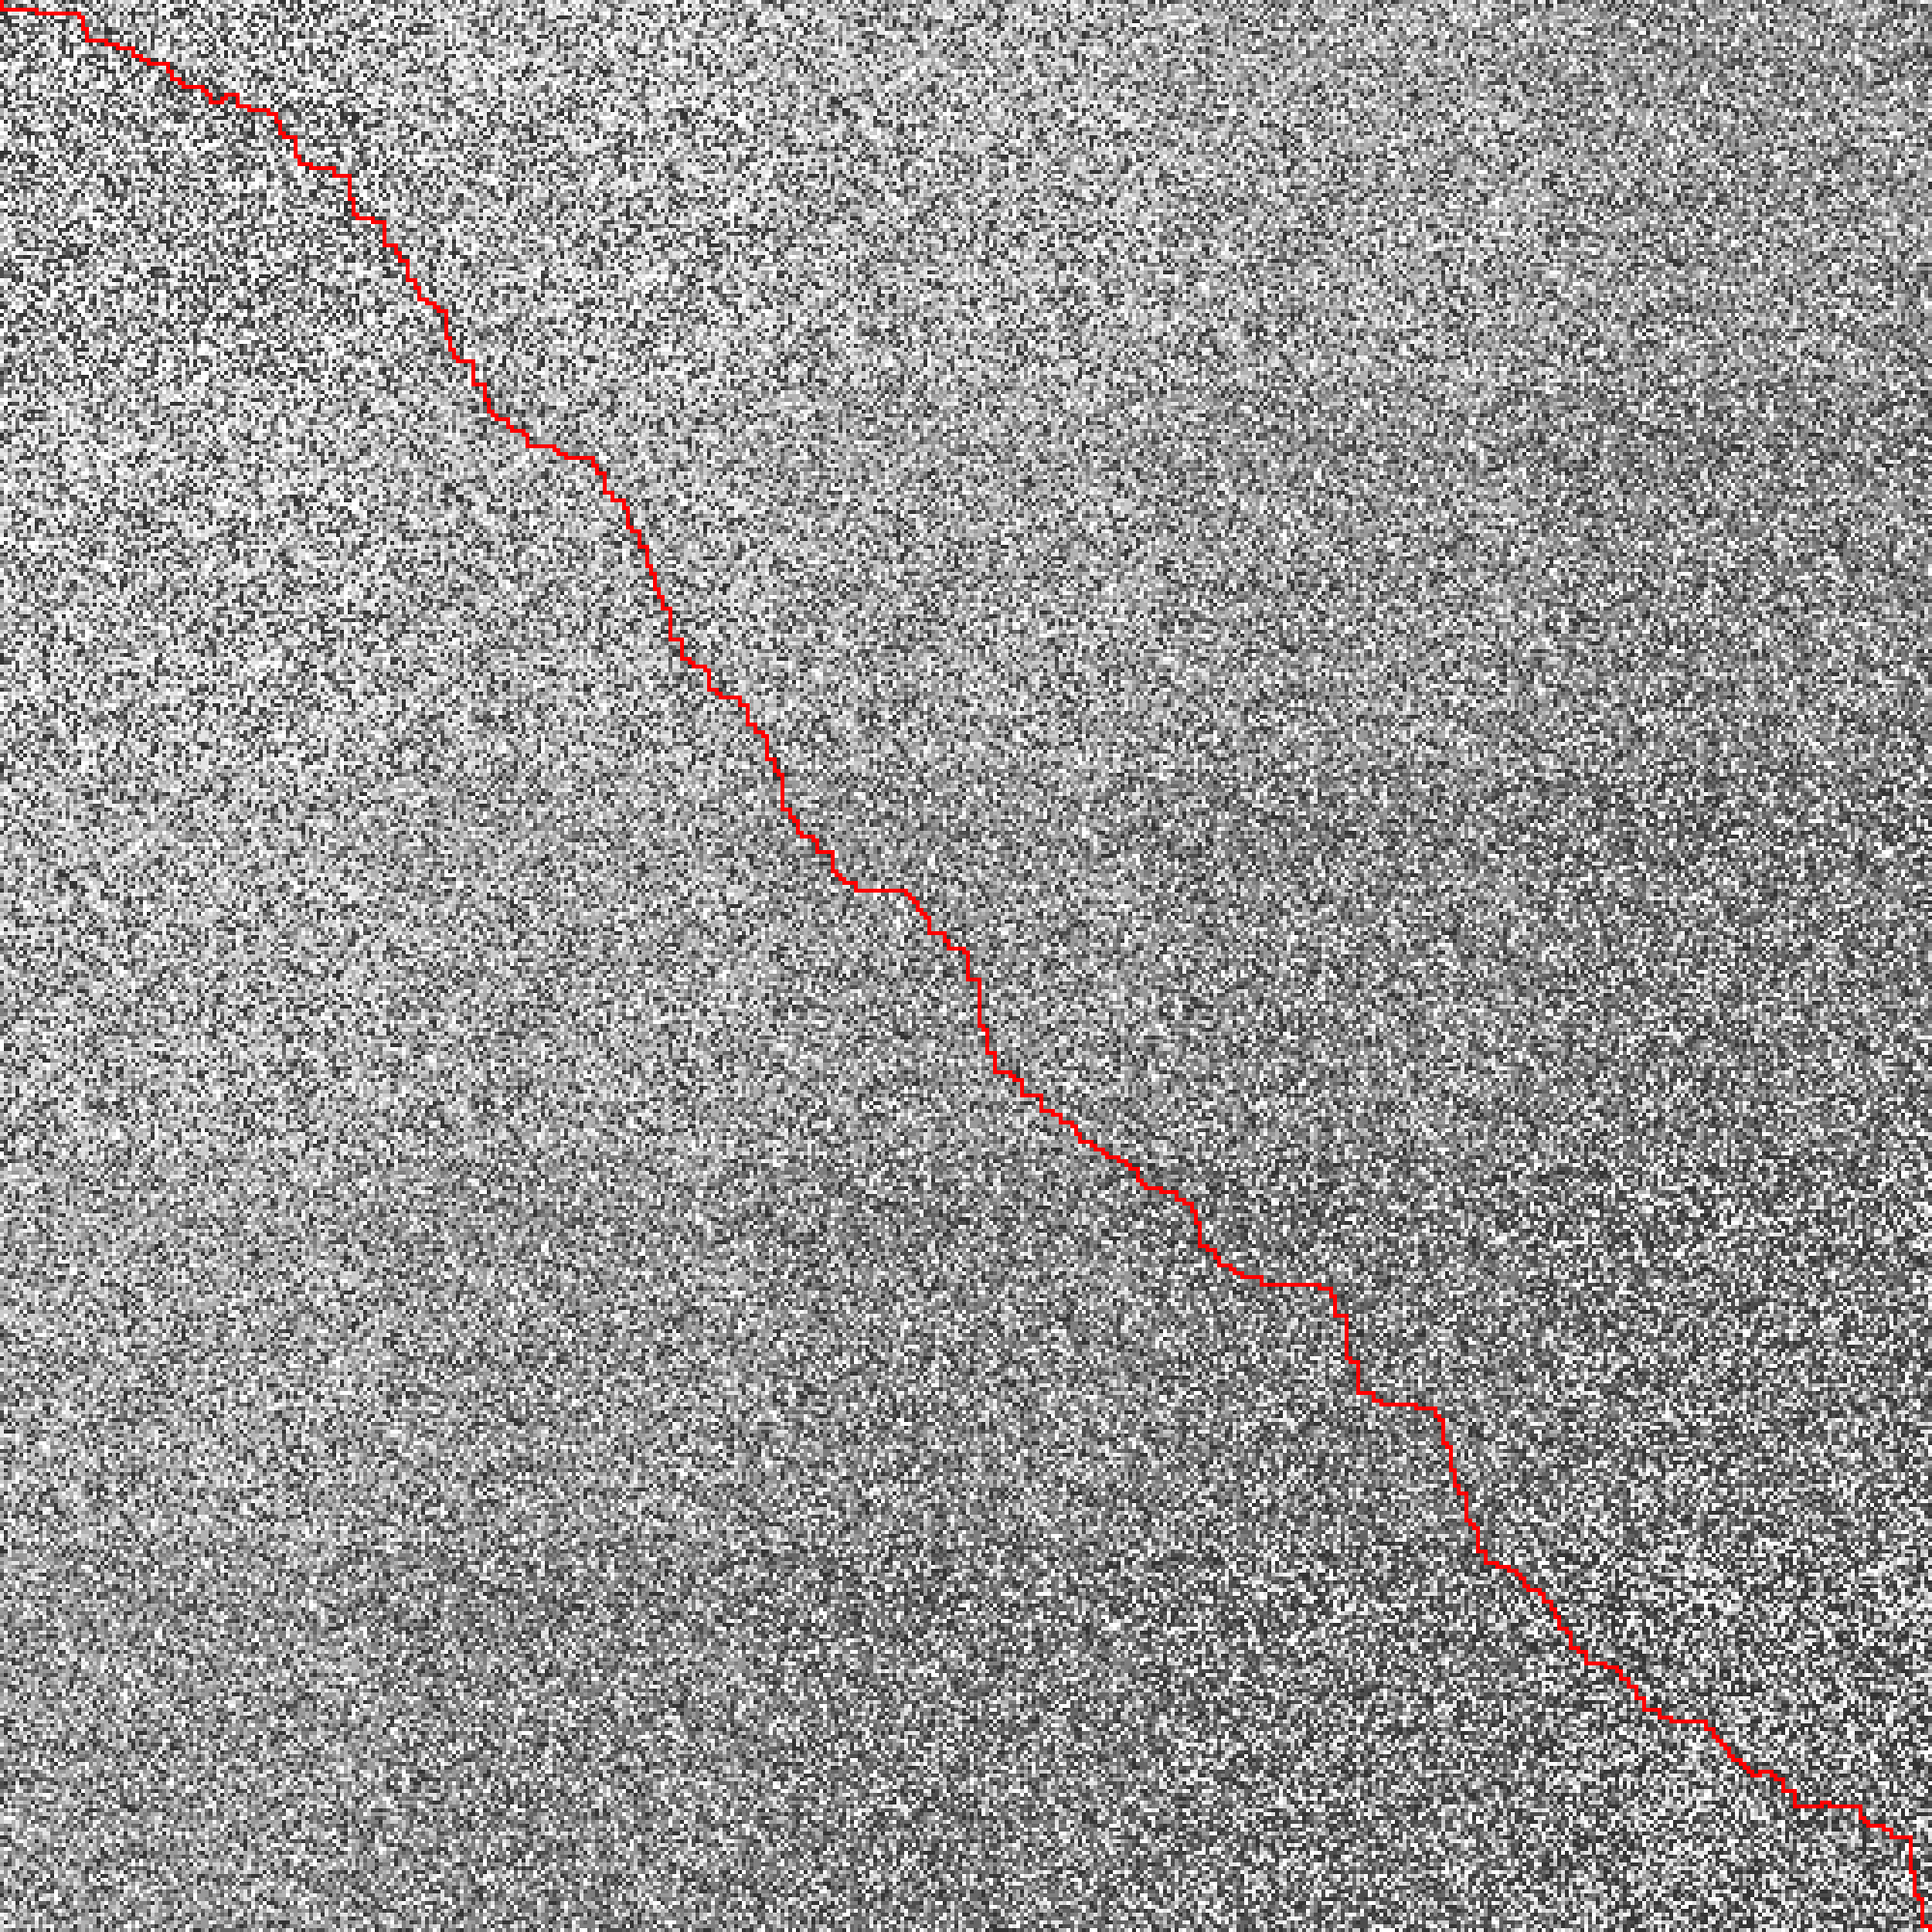

In [74]:
img500